<a href="https://colab.research.google.com/github/nhjung-phd/Papers/blob/main/factor2025/factor_rl_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd

# BTC-USD 시세 조회 (Ticker API)
url = "https://api.blockchain.com/v3/exchange/tickers/BTC-USD"
response = requests.get(url)

# 응답 결과를 DataFrame으로 변환
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame([data])
    print(df)
else:
    print("API 요청 실패:", response.status_code)


    symbol  price_24h  volume_24h  last_trade_price
0  BTC-USD   104300.0    0.383483          103000.0


In [ ]:
import yfinance as yf

btc = yf.download('BTC-USD', start='2014-01-01', end='2024-12-31')
print(btc.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100


In [ ]:
# Colab에서는 설치 필요
!pip install yfinance

import yfinance as yf
import pandas as pd

# 1. BTC 가격 데이터 다운로드
btc = yf.download("BTC-USD", start="2014-01-01", end="2024-12-31")

# 2. 팩터 계산
btc['Return'] = btc['Close'].pct_change()
btc['Volatility'] = btc['Close'].rolling(window=20).std()
btc['Volume_z'] = (btc['Volume'] - btc['Volume'].rolling(30).mean()) / btc['Volume'].rolling(30).std()

# ✅ 3. MA_deviation 안정적으로 계산
ma20_series = btc['Close'].rolling(window=20).mean()
btc['MA_deviation'] = (btc['Close'] - ma20_series) / ma20_series

# 4. 결측치 제거
btc.dropna(inplace=True)

# 결과 확인
btc.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return,Volatility,Volume_z,MA_deviation
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,
Date,,,,,,,,,
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,-0.035284,3284.365678,-0.780298,-0.038130
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,-0.017022,3499.260316,-0.561424,-0.051762
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,0.010610,3585.266863,-1.488611,-0.038762
2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267,-0.017167,3776.246125,-1.237032,-0.053399
2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691,-0.009484,3997.177449,-0.377312,-0.060459


In [ ]:
!pip install yfinance

import yfinance as yf
import pandas as pd

# 1️⃣ 분석 대상 자산 설정
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]

# 2️⃣ 가격 데이터 수집 (종가 기준)
price = yf.download(assets, start="2019-01-01", end="2024-12-31")['Close'].dropna()

# 3️⃣ 수익률 계산
returns = price.pct_change().dropna()

# 4️⃣ 20일 이동 평균 괴리율 (모멘텀/추세 팩터)
ma20 = price.rolling(window=20).mean()
ma_deviation = (price - ma20) / ma20

# 5️⃣ 20일 변동성 (리스크 팩터)
volatility = returns.rolling(window=20).std()

# 6️⃣ 거래량 z-score (유동성 팩터)
volume = yf.download(assets, start="2019-01-01", end="2024-12-31")['Volume'].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

# 7️⃣ 팩터 통합
factors = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_deviation.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna()

# 8️⃣ 확인
factors.tail()


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


Ticker,BNB-USD_Ret,BTC-USD_Ret,ETH-USD_Ret,SOL-USD_Ret,BNB-USD_Vol,BTC-USD_Vol,ETH-USD_Vol,SOL-USD_Vol,BNB-USD_Dev,BTC-USD_Dev,ETH-USD_Dev,SOL-USD_Dev,BNB-USD_VolZ,BTC-USD_VolZ,ETH-USD_VolZ,SOL-USD_VolZ
Date,,,,,,,,,,,,,,,,
2024-12-26,-0.019887,-0.035284,-0.046378,-0.046896,0.031521,0.025879,0.034909,0.040717,-0.016700,-0.038130,-0.094000,-0.103111,-1.273588,-0.780298,-1.160704,-1.230230
2024-12-27,0.003006,-0.017022,-0.000693,-0.023322,0.030887,0.026096,0.034910,0.040606,-0.009510,-0.051762,-0.086256,-0.112457,-0.583124,-0.561424,-0.967990,-1.193866
2024-12-28,0.044218,0.010610,0.020723,0.060845,0.032645,0.026021,0.035472,0.043771,0.035947,-0.038762,-0.059474,-0.048889,-0.549132,-1.488611,-1.550136,-1.415227
2024-12-29,-0.037734,-0.017167,-0.014241,-0.027020,0.029493,0.024963,0.032186,0.040564,-0.003417,-0.053399,-0.068107,-0.068318,-0.781691,-1.237032,-1.521618,-1.343012
2024-12-30,0.014979,-0.009484,0.002054,0.006766,0.029287,0.024988,0.031912,0.040585,0.009541,-0.060459,-0.062601,-0.056735,-0.612352,-0.377312,-0.625723,-0.858728


In [ ]:
# 📌 필요한 패키지 설치 (Colab에서 실행 시)
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 1️⃣ 자산 설정 및 데이터 수집
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
price = yf.download(assets, start="2019-01-01", end="2024-12-31")['Close'].dropna()
returns = price.pct_change().dropna()

# 2️⃣ 팩터 계산
volatility = returns.rolling(window=20).std()
ma20 = price.rolling(window=20).mean()
ma_deviation = (price - ma20) / ma20
volume = yf.download(assets, start="2019-01-01", end="2024-12-31")['Volume'].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

# 3️⃣ 팩터 통합
factor_df = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_deviation.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna()

# 4️⃣ 월간 수익률 계산 (Sharpe/Sortino 최적화용)
monthly_returns = returns.resample('M').sum().dropna()

# 5️⃣ Sharpe 비율 최적화 함수
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_return - risk_free_rate) / port_volatility  # minimize

# 6️⃣ Sortino 비율 최적화 함수
def sortino_ratio(weights, mean_returns, returns, target=0.0):
    port_return = np.dot(weights, mean_returns)
    downside_risk = np.sqrt(np.mean(np.minimum(returns @ weights - target, 0) ** 2))
    return -(port_return - target) / downside_risk

# 7️⃣ 최적화 세팅
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
n_assets = len(mean_returns)
init_guess = [1/n_assets] * n_assets
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# 8️⃣ Sharpe 비율 기준 최적화
opt_sharpe = minimize(sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# 9️⃣ Sortino 비율 기준 최적화
opt_sortino = minimize(sortino_ratio, init_guess, args=(mean_returns, monthly_returns),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# 🔟 결과 출력
weights_df = pd.DataFrame({
    "Asset": mean_returns.index,
    "Sharpe_Opt_Weight": opt_sharpe.x,
    "Sortino_Opt_Weight": opt_sortino.x
})

print("📊 최적화된 포트폴리오 가중치")
print(weights_df)


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
<ipython-input-18-99984c219776>:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').sum().dropna()


📊 최적화된 포트폴리오 가중치
     Asset  Sharpe_Opt_Weight  Sortino_Opt_Weight
0  BNB-USD           0.168712        7.530582e-01
1  BTC-USD           0.352239        6.938894e-17
2  ETH-USD           0.278200        0.000000e+00
3  SOL-USD           0.200849        2.469418e-01


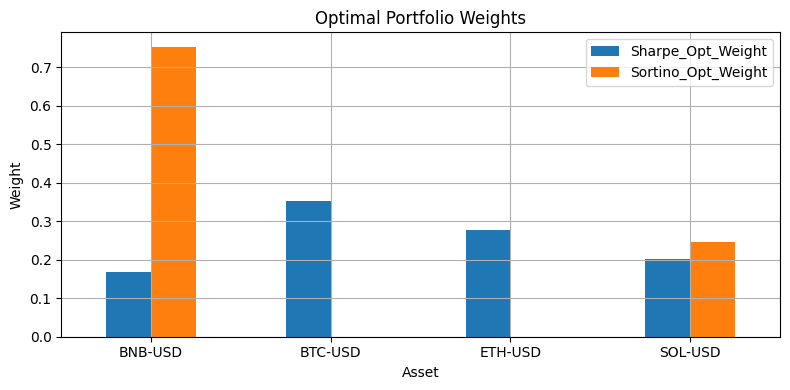

In [ ]:
import matplotlib.pyplot as plt

weights_df.set_index("Asset").plot.bar(figsize=(8,4), title="Optimal Portfolio Weights")
plt.ylabel("Weight")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 강화학습 기반 동적 자산배분: PPO + Sharpe 최적화 환경
# 사전 설치 필요: !pip install yfinance stable-baselines3

import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# 📌 1. 환경 클래스 정의
class PortfolioEnv(gym.Env):
    def __init__(self, returns, factors, window_size=30):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.factors = factors
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window_size = window_size
        self.max_step = len(factors) - window_size
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.step_count = 0
        self.weights = np.array([1/self.n_assets] * self.n_assets)
        self.portfolio_returns = []
        self.current_idx = self.window_size
        return self._get_observation()

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / np.sum(action + 1e-8)
        r_t = self.returns.iloc[self.current_idx].values
        port_return = np.dot(action, r_t)
        self.portfolio_returns.append(port_return)

        reward = self._sharpe_reward()
        self.weights = action
        self.step_count += 1
        self.current_idx += 1

        done = self.step_count >= self.max_step
        obs = self._get_observation()
        info = {"portfolio_return": port_return}
        return obs, reward, done, info

    def _get_observation(self):
        return self.factors.iloc[self.current_idx - self.window_size:self.current_idx].values

    def _sharpe_reward(self):
        if len(self.portfolio_returns) < 2:
            return 0
        r = np.array(self.portfolio_returns[-30:])
        return (np.mean(r)) / (np.std(r) + 1e-6)

# 📌 2. 데이터 준비 (예: BTC, ETH, BNB, SOL)
import yfinance as yf
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
price = yf.download(assets, start="2019-01-01", end="2024-12-31")["Close"].dropna()
returns = price.pct_change().dropna()

volatility = returns.rolling(20).std()
ma = price.rolling(20).mean()
ma_dev = (price - ma) / ma
volume = yf.download(assets, start="2019-01-01", end="2024-12-31")["Volume"].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

factor_df = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_dev.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna()

# 📌 3. 환경 초기화
env = DummyVecEnv([lambda: PortfolioEnv(returns=returns, factors=factor_df)])

# 📌 4. PPO 에이전트 훈련
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

# 📌 5. 결과 테스트
obs = env.reset()
for _ in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"Reward: {rewards[0]:.5f}, Portfolio Return: {info[0]['portfolio_return']:.5f}")

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 932  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014439669 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.65       |
|    explained_variance   | 0.0651      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.657       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.988       |
|    value_loss           | 2.85        |
-----------------

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 627  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 549         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016002577 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | -0.0326     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.722       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0315     |
|    std                  | 0.997       |
|    value_loss           | 2.4         |
-----------------

TypeError: no numeric data to plot

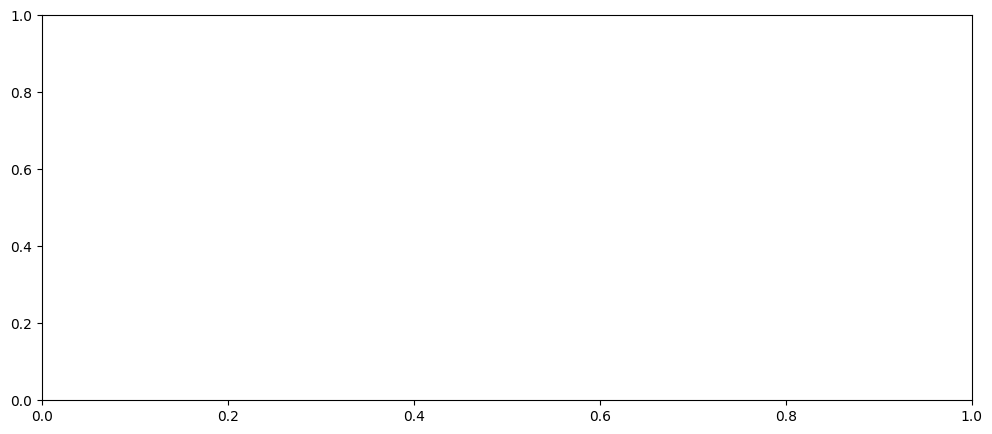

In [ ]:
# 강화학습 기반 동적 자산배분 (실제 리밸런싱 및 매수/매도 반영 + 날짜 기준 그래프)
# 사전 설치 필요: !pip install yfinance stable-baselines3

import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# 📌 1. 환경 클래스 정의
class PortfolioEnv(gym.Env):
    def __init__(self, returns, prices, factors, window_size=30, fee=0.001):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.prices = prices
        self.factors = factors
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window_size = window_size
        self.max_step = len(factors) - window_size - 1
        self.fee = fee

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.step_count = 0
        self.current_idx = self.window_size
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.dates = []
        return self._get_observation()

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        price_today = self.prices.iloc[self.current_idx].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value

        cost = np.sum(np.abs(trade_value) * self.fee)
        self.cash -= cost

        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)

        price_next = self.prices.iloc[self.current_idx + 1].values
        portfolio_value_now = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (portfolio_value_now - self.portfolio_value[-1]) / self.portfolio_value[-1]
        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(portfolio_value_now)
        self.dates.append(self.prices.index[self.current_idx + 1])

        self.current_idx += 1
        self.step_count += 1
        done = self.step_count >= self.max_step or self.current_idx + 1 >= len(self.prices)

        obs = self._get_observation()
        reward = self._sharpe_reward()
        info = {"portfolio_return": port_return, "portfolio_value": portfolio_value_now, "cost": cost}
        return obs, reward, done, info

    def _get_observation(self):
        return self.factors.iloc[self.current_idx - self.window_size:self.current_idx].values

    def _sharpe_reward(self):
        if len(self.portfolio_returns) < 2:
            return 0
        r = np.array(self.portfolio_returns[-30:])
        return np.mean(r) / (np.std(r) + 1e-6)

# 📌 2. 데이터 준비
import yfinance as yf
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
data = yf.download(assets, start="2019-01-01", end="2024-12-31")
price = data["Close"].dropna()
returns = price.pct_change().dropna()

volatility = returns.rolling(20).std()
ma = price.rolling(20).mean()
ma_dev = (price - ma) / ma
volume = data["Volume"].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

factor_df = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_dev.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna()

# 📌 3. 환경 초기화
env_instance = PortfolioEnv(returns=returns, prices=price, factors=factor_df)
env = DummyVecEnv([lambda: env_instance])

# 📌 4. PPO 에이전트 훈련
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

# 📌 5. 결과 테스트 및 날짜 기준 수익률 시각화
obs = env.reset()
for _ in range(env_instance.max_step):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    if dones[0]:
        break

# 날짜와 매핑된 포트폴리오 수익률 시각화
min_len = min(len(env_instance.portfolio_value) - 1, len(env_instance.dates))
portfolio_series = pd.Series(env_instance.portfolio_value[1:1+min_len], index=env_instance.dates[:min_len])

plt.figure(figsize=(12, 5))
portfolio_series.plot(label="Portfolio Value")
plt.title("Cumulative Portfolio Value by Date")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 688  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 501         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014956536 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | 0.0386      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.7         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.995       |
|    value_loss           | 4.36        |
-----------------

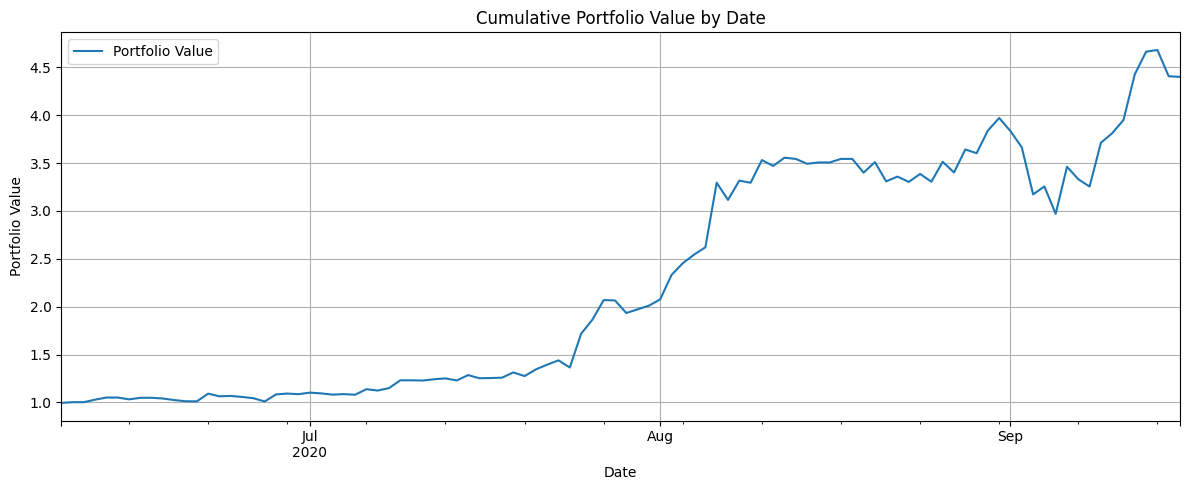

In [ ]:
# 강화학습 기반 동적 자산배분 (실제 리밸런싱 및 매수/매도 반영 + 날짜 기준 그래프)
# 사전 설치 필요: !pip install yfinance stable-baselines3

import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# 📌 1. 환경 클래스 정의
class PortfolioEnv(gym.Env):
    def __init__(self, returns, prices, factors, window_size=30, fee=0.001):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.prices = prices
        self.factors = factors
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window_size = window_size
        self.max_step = len(factors) - window_size - 1
        self.fee = fee

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.step_count = 0
        self.current_idx = self.window_size
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.dates = []
        # Ensure we can take at least one step after reset
        if self.current_idx >= len(self.prices) - 1:
             raise ValueError("Not enough data for initial window and at least one step.")

        return self._get_observation()

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        price_today = self.prices.iloc[self.current_idx].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value

        cost = np.sum(np.abs(trade_value) * self.fee)
        self.cash -= cost

        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)

        # Check if there is a next step available before accessing prices.iloc[self.current_idx + 1]
        if self.current_idx + 1 >= len(self.prices):
             done = True
             obs = self._get_observation() # Return current state or handle end of episode
             reward = self._sharpe_reward()
             # Use the last calculated portfolio value if no next price is available
             info = {"portfolio_return": 0.0, "portfolio_value": self.portfolio_value[-1], "cost": cost}
             return obs, reward, done, info


        price_next = self.prices.iloc[self.current_idx + 1].values
        portfolio_value_now = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (portfolio_value_now - self.portfolio_value[-1]) / self.portfolio_value[-1]
        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(portfolio_value_now)
        self.dates.append(self.prices.index[self.current_idx + 1])

        self.current_idx += 1
        self.step_count += 1
        # The condition for done should only check against max_step if current_idx + 1 is still within bounds
        done = self.step_count >= self.max_step

        obs = self._get_observation()
        reward = self._sharpe_reward()
        info = {"portfolio_return": port_return, "portfolio_value": portfolio_value_now, "cost": cost}
        return obs, reward, done, info


    def _get_observation(self):
        # Ensure there's enough data for the observation window
        start_idx = self.current_idx - self.window_size
        if start_idx < 0 or self.current_idx > len(self.factors):
             # This should ideally not happen with proper reset logic, but adding a safeguard
             print(f"Warning: Observation window out of bounds. Start: {start_idx}, Current: {self.current_idx}, Factors len: {len(self.factors)}")
             # Return a placeholder observation or handle error
             # For simplicity, returning the available window or zeros
             if start_idx < 0: start_idx = 0
             if self.current_idx > len(self.factors): self.current_idx = len(self.factors)
             return self.factors.iloc[start_idx:self.current_idx].values
        return self.factors.iloc[start_idx:self.current_idx].values


    def _sharpe_reward(self):
        if len(self.portfolio_returns) < 2:
            return 0
        r = np.array(self.portfolio_returns[-30:])
        # Avoid division by zero if std is zero
        std_dev = np.std(r)
        return np.mean(r) / (std_dev + 1e-6)

# 📌 2. 데이터 준비
import yfinance as yf
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
data = yf.download(assets, start="2019-01-01", end="2024-12-31")
price = data["Close"].dropna()
returns = price.pct_change().dropna()

volatility = returns.rolling(20).std()
ma = price.rolling(20).mean()
ma_dev = (price - ma) / ma
volume = data["Volume"].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

# Ensure all factor dataframes have the same index before concatenating
# This step is crucial if dropna() resulted in different indices
common_index = returns.index.intersection(volatility.index).intersection(ma_dev.index).intersection(volume_z.index)

returns = returns.loc[common_index]
volatility = volatility.loc[common_index]
ma_dev = ma_dev.loc[common_index]
volume_z = volume_z.loc[common_index]
price_aligned = price.loc[common_index] # Also align price data

factor_df = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_dev.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna() # Dropna again just in case concat introduced NaNs


# 📌 3. 환경 초기화
# Pass the aligned price data to the environment
env_instance = PortfolioEnv(returns=returns.loc[factor_df.index], prices=price_aligned.loc[factor_df.index], factors=factor_df)
env = DummyVecEnv([lambda: env_instance])

# 📌 4. PPO 에이gent 훈련
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

# 📌 5. 결과 테스트 및 날짜 기준 수익률 시각화
obs = env.reset()
# Run the testing loop for a sufficient number of steps, but not exceeding max_step
# Let's run for at most 100 steps for a quick test, or use env_instance.max_step for full test
test_steps = min(env_instance.max_step, 100) # Limit testing steps for faster visualization
for _ in range(test_steps):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    # The dones flag should propagate correctly from the environment's step method
    if dones[0]:
        print("Episode finished during testing.")
        break # Break the testing loop if the environment signals done


# 날짜와 매핑된 포트폴리오 수익률 시각화
# Use the accumulated portfolio_value and dates directly from the environment instance
# Ensure there's data to plot
if len(env_instance.portfolio_value) > 1 and len(env_instance.dates) > 0:
    # The portfolio_value list includes the initial value at index 0.
    # Dates and subsequent portfolio values start from index 1.
    # Ensure lists are aligned and have data before creating series
    plot_values = env_instance.portfolio_value[1:]
    plot_dates = env_instance.dates

    # Ensure plot_values and plot_dates have the same length
    min_plot_len = min(len(plot_values), len(plot_dates))
    portfolio_series = pd.Series(plot_values[:min_plot_len], index=plot_dates[:min_plot_len])

    if not portfolio_series.empty:
        plt.figure(figsize=(12, 5))
        portfolio_series.plot(label="Portfolio Value")
        plt.title("Cumulative Portfolio Value by Date")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Portfolio series is empty, cannot plot.")
else:
    print("Not enough data collected during testing to plot the portfolio value.")

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 789  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 617         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016506677 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.66       |
|    explained_variance   | -0.0114     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.07        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.992       |
|    value_loss           | 3.72        |
-----------------

<ipython-input-33-4961b1f16891>:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = series[-1] / series[0] - 1
<ipython-input-33-4961b1f16891>:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1



📊 Performance Comparison
Cumulative Return         PPO: 0.9116    BTC: 0.1204
Annualized Return         PPO: 4.1180    BTC: 0.3317
Annualized Volatility     PPO: 0.9497    BTC: 0.3814
Sharpe Ratio              PPO: 4.3361    BTC: 0.8697
Max Drawdown              PPO: -0.2878    BTC: -0.1732


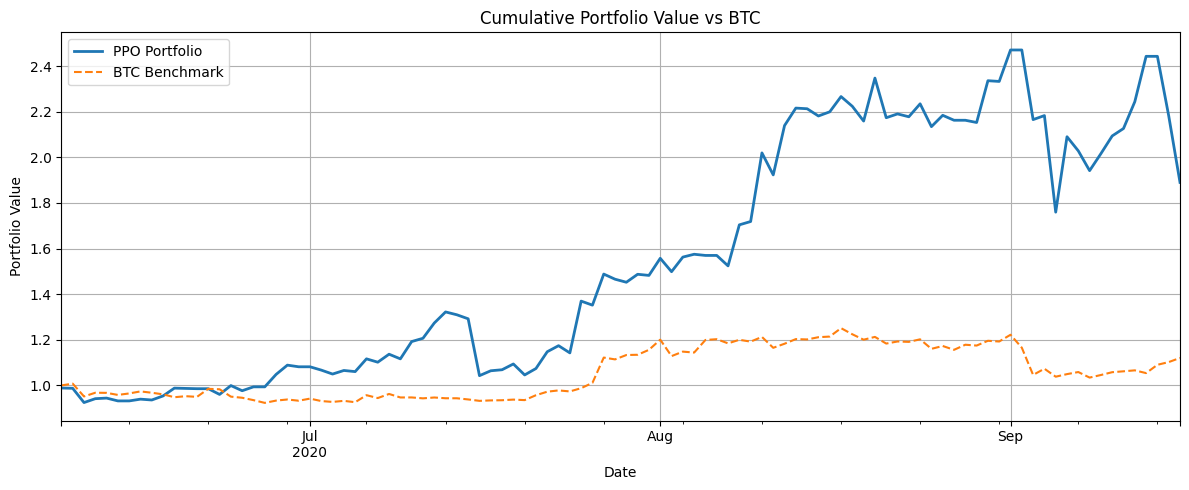

In [ ]:
# 강화학습 기반 동적 자산배분 (벤치마크 비교 및 성과지표 추가)
# 사전 설치 필요: !pip install yfinance stable-baselines3

import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# 📌 1. 환경 클래스 정의 (변경 없음, 생략)
# ... (생략: PortfolioEnv 클래스 정의는 이전과 동일하게 유지)

# 📌 2. 데이터 준비
import yfinance as yf
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
data = yf.download(assets, start="2019-01-01", end="2024-12-31")
price = data["Close"].dropna()
returns = price.pct_change().dropna()

volatility = returns.rolling(20).std()
ma = price.rolling(20).mean()
ma_dev = (price - ma) / ma
volume = data["Volume"].dropna()
volume_z = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()

common_index = returns.index.intersection(volatility.index).intersection(ma_dev.index).intersection(volume_z.index)
returns = returns.loc[common_index]
volatility = volatility.loc[common_index]
ma_dev = ma_dev.loc[common_index]
volume_z = volume_z.loc[common_index]
price_aligned = price.loc[common_index]

factor_df = pd.concat([
    returns.add_suffix("_Ret"),
    volatility.add_suffix("_Vol"),
    ma_dev.add_suffix("_Dev"),
    volume_z.add_suffix("_VolZ")
], axis=1).dropna()

# 📌 3. 환경 초기화
env_instance = PortfolioEnv(returns=returns.loc[factor_df.index], prices=price_aligned.loc[factor_df.index], factors=factor_df)
env = DummyVecEnv([lambda: env_instance])

# 📌 4. PPO 에이전트 훈련
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

# 📌 5. 테스트 실행 및 수익률 기록
obs = env.reset()
test_steps = min(env_instance.max_step, 100)
for _ in range(test_steps):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    if dones[0]:
        print("Episode finished during testing.")
        break

# ✅ 누적 수익률 계산 (PPO)
plot_values = env_instance.portfolio_value[1:]
plot_dates = env_instance.dates
min_plot_len = min(len(plot_values), len(plot_dates))
ppo_series = pd.Series(plot_values[:min_plot_len], index=plot_dates[:min_plot_len])

# ✅ 벤치마크: BTC 단독 투자
btc_price = price_aligned["BTC-USD"].loc[ppo_series.index]
btc_returns = btc_price.pct_change().fillna(0)
btc_cumulative = (1 + btc_returns).cumprod()

# ✅ 성과 지표 계산 함수 정의
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (annualized_return - 0.0) / (annualized_vol + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": mdd
    }

ppo_perf = performance_metrics(ppo_series)
btc_perf = performance_metrics(btc_cumulative)

# ✅ 성과 지표 출력
print("\n📊 Performance Comparison")
for metric in ppo_perf:
    print(f"{metric:<25} PPO: {ppo_perf[metric]:.4f}    BTC: {btc_perf[metric]:.4f}")

# ✅ 시각화
plt.figure(figsize=(12, 5))
ppo_series.plot(label="PPO Portfolio", linewidth=2)
btc_cumulative.plot(label="BTC Benchmark", linestyle="--")
plt.title("Cumulative Portfolio Value vs BTC")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



📊 Performance Comparison

Sharpe Portfolio
Cumulative Return        : 4.8082
Annualized Return        : 0.3030
Annualized Volatility    : 0.6869
Sharpe Ratio             : 0.4411
Max Drawdown             : -0.9273

Beta Portfolio
Cumulative Return        : 28.0357
Annualized Return        : 0.6599
Annualized Volatility    : 0.7074
Sharpe Ratio             : 0.9330
Max Drawdown             : -0.8936

BTC Portfolio
Cumulative Return        : 8.7921
Annualized Return        : 0.4095
Annualized Volatility    : 0.5056
Sharpe Ratio             : 0.8100
Max Drawdown             : -0.7663


<ipython-input-38-2ed4d326ee73>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = series[-1] / series[0] - 1
<ipython-input-38-2ed4d326ee73>:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1


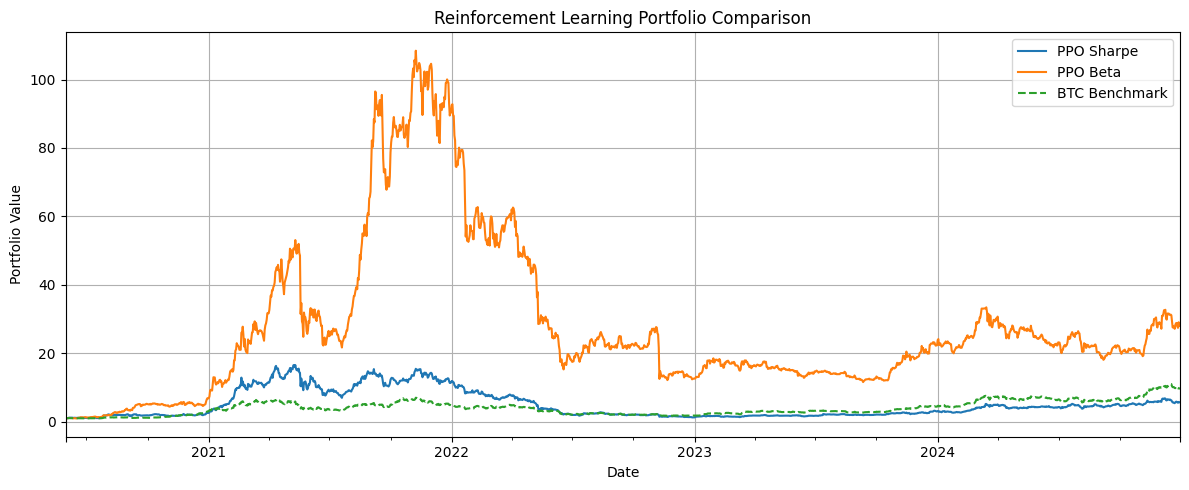

In [ ]:
# 강화학습 기반 자산배분 비교: Sharpe 최대화 vs Beta 가중합 최대화 vs BTC 단독 투자
# PPO 기반 리밸런싱 전략 구현 포함

import gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import random
import torch

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

# 📌 1. 데이터 수집
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
data = yf.download(assets, start="2019-01-01", end="2024-12-31")
price = data["Close"].dropna()
returns = price.pct_change().dropna()

# 📌 2. 팩터 정의
momentum = price.pct_change(20)
volatility = returns.rolling(20).std()

# 팩터 입력 데이터 정리
factor_data = pd.concat([
    momentum.add_suffix("_mom"),
    volatility.add_suffix("_vol")
], axis=1).dropna()

common_index = returns.index.intersection(factor_data.index)
returns = returns.loc[common_index]
price = price.loc[common_index]
factor_data = factor_data.loc[common_index]

# 📌 3. PPO 환경 정의 (Sharpe 또는 Beta 기준)
class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super(PPOPortfolioEnv, self).__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 30
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.window, factors.shape[1]), dtype=np.float32)
        self.objective = objective

    def reset(self):
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current - self.window:self.current].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        price_today = self.price.iloc[self.current].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value

        cost = np.sum(np.abs(trade_value) * 0.001)
        self.cash -= cost
        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)

        price_next = self.price.iloc[self.current + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - self.portfolio_value[-1]) / self.portfolio_value[-1]

        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current += 1

        done = self.current + 1 >= len(self.returns)
        obs = self.factors.iloc[self.current - self.window:self.current].values

        if self.objective == "sharpe":
            r = np.array(self.portfolio_returns[-30:])
            reward = np.mean(r) / (np.std(r) + 1e-6)
        elif self.objective == "beta":
            # 베타는 모멘텀 팩터에 대한 민감도 누적치를 최대화
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets]].values
            reward = np.dot(action, beta_score)
        else:
            reward = port_return

        return obs, reward, done, {"portfolio_value": port_value_next}

# 📌 4. PPO 훈련 함수
def train_ppo_env(objective):
    env_fn = lambda: PPOPortfolioEnv(returns, factor_data, price, objective=objective)
    env = DummyVecEnv([env_fn])
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=20000)
    return model, env_fn

# 📌 5. 실행 및 시뮬레이션
def evaluate_model(model, env_fn):
    env = env_fn()
    obs = env.reset()
    values = []
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        values.append(info["portfolio_value"])
        if done:
            break
    return pd.Series(values, index=price.index[env.window+1:env.window+1+len(values)])

# PPO 훈련 및 평가
ppo_sharpe, env_sharpe = train_ppo_env("sharpe")
ppo_beta, env_beta = train_ppo_env("beta")

series_sharpe = evaluate_model(ppo_sharpe, env_sharpe)
series_beta = evaluate_model(ppo_beta, env_beta)
btc_returns = returns["BTC-USD"].loc[series_sharpe.index]
series_btc = (1 + btc_returns).cumprod()

# 📈 성과 지표 함수
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (annualized_return - 0.0) / (annualized_vol + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": mdd
    }

# 📊 성과 비교 출력
print("\n📊 Performance Comparison")
for name, series in zip(["Sharpe", "Beta", "BTC"], [series_sharpe, series_beta, series_btc]):
    perf = performance_metrics(series)
    print(f"\n{name} Portfolio")
    for k, v in perf.items():
        print(f"{k:<25}: {v:.4f}")

# 📊 시각화
plt.figure(figsize=(12, 5))
series_sharpe.plot(label="PPO Sharpe")
series_beta.plot(label="PPO Beta")
series_btc.plot(label="BTC Benchmark", linestyle="--")
plt.title("Reinforcement Learning Portfolio Comparison")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
!pip install shimmy>=0.2.1

In [2]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 776  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 528         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007700679 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | 9.95e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.997       |
|    value_loss           | 1.57e+06    |
-----------------

<ipython-input-5-7f43d870f2bc>:140: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = series[-1] / series[0] - 1
<ipython-input-5-7f43d870f2bc>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1


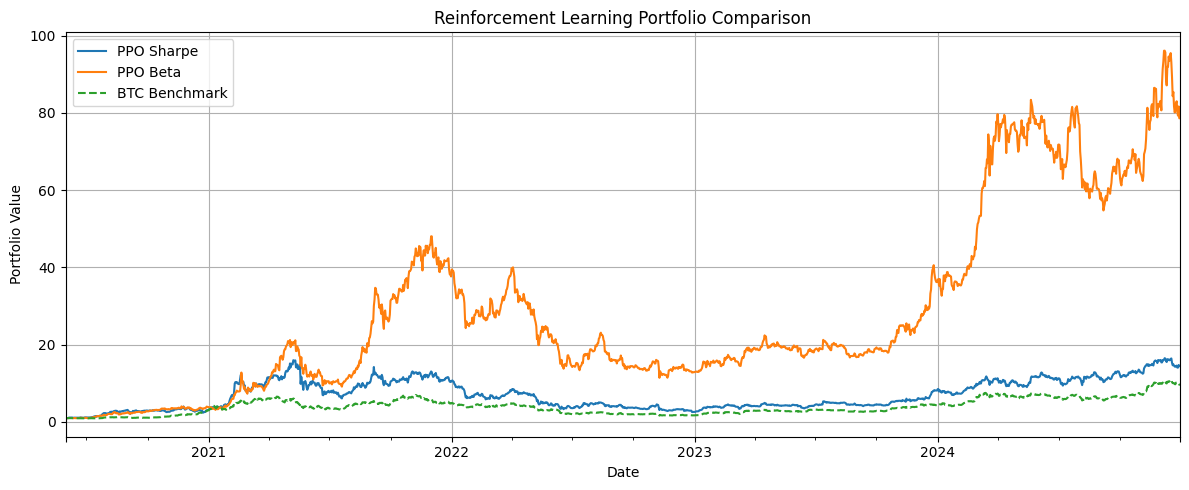

In [5]:
# 강화학습 기반 자산배분 비교: Sharpe 최대화 vs Beta 가중합 최대화 vs BTC 단독 투자
# PPO 기반 리밸런싱 전략 구현 포함

import gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# 📌 1. 데이터 수집
assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
data = yf.download(assets, start="2019-01-01", end="2024-12-31")
price = data["Close"].dropna()
returns = price.pct_change().dropna()

# 📌 2. 팩터 정의
momentum = price.pct_change(20)
volatility = returns.rolling(20).std()

# 팩터 입력 데이터 정리
factor_data = pd.concat([
    momentum.add_suffix("_mom"),
    volatility.add_suffix("_vol")
], axis=1).dropna()

common_index = returns.index.intersection(factor_data.index)
returns = returns.loc[common_index]
price = price.loc[common_index]
factor_data = factor_data.loc[common_index]

# 📌 3. PPO 환경 정의 (Sharpe 또는 Beta 기준)
class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super(PPOPortfolioEnv, self).__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 30
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.window, factors.shape[1]), dtype=np.float32)
        self.objective = objective

    def reset(self):
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current - self.window:self.current].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        price_today = self.price.iloc[self.current].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value

        cost = np.sum(np.abs(trade_value) * 0.001)
        self.cash -= cost
        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)

        price_next = self.price.iloc[self.current + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - self.portfolio_value[-1]) / self.portfolio_value[-1]

        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current += 1

        done = self.current + 1 >= len(self.returns)
        obs = self.factors.iloc[self.current - self.window:self.current].values

        if self.objective == "sharpe":
            r = np.array(self.portfolio_returns[-30:])
            reward = np.mean(r) / (np.std(r) + 1e-6)
        elif self.objective == "beta":
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets]].values
            reward = np.dot(action, beta_score)
        else:
            reward = port_return

        return obs, reward, done, {"portfolio_value": port_value_next}

# 📌 4. PPO 훈련 함수
def train_ppo_env(objective):
    env_fn = lambda: PPOPortfolioEnv(returns, factor_data, price, objective=objective)
    env = DummyVecEnv([env_fn])
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=30000)
    return model, env_fn

# 📌 5. 실행 및 시뮬레이션
def evaluate_model(model, env_fn):
    env = env_fn()
    obs = env.reset()
    values = []
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        values.append(info["portfolio_value"])
        if done:
            break
    return pd.Series(values, index=price.index[env.window+1:env.window+1+len(values)])

# PPO 훈련 및 평가
ppo_sharpe, env_sharpe = train_ppo_env("sharpe")
ppo_beta, env_beta = train_ppo_env("beta")

series_sharpe = evaluate_model(ppo_sharpe, env_sharpe)
series_beta = evaluate_model(ppo_beta, env_beta)
btc_returns = returns["BTC-USD"].loc[series_sharpe.index]
series_btc = (1 + btc_returns).cumprod()

# 📈 성과 지표 함수
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (annualized_return - 0.0) / (annualized_vol + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": mdd
    }

# 📊 성과 비교 출력
print("\n📊 Performance Comparison")
for name, series in zip(["Sharpe", "Beta", "BTC"], [series_sharpe, series_beta, series_btc]):
    perf = performance_metrics(series)
    print(f"\n{name} Portfolio")
    for k, v in perf.items():
        print(f"{k:<25}: {v:.4f}")

# 📊 시각화
plt.figure(figsize=(12, 5))
series_sharpe.plot(label="PPO Sharpe")
series_beta.plot(label="PPO Beta")
series_btc.plot(label="BTC Benchmark", linestyle="--")
plt.title("Reinforcement Learning Portfolio Comparison")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()